# Automatic geological modelling

This notebook uses map2loop to deconstruct a geological map into an input dataset for LoopStructural. The notebook is intended to be run as a part of the subsurface transform 21 workshop by Lachlan Grose and Mark Jessell. This notebook uses data provided by the Geological Survey of Western Australia ([license](licenses/gswalicence.pdf)).

Using this notebook you will:
* deconstruct a geological map using map2loop and augment the dataset for input into LoopStructural
* understand how the dataset is interpreted by LoopStructural
* build a geological model using LoopStructural
* visualise the geological model using lavavu


If you want to try and use map2loop with your own data there is a guide [here](map2loop_extras/Using%20map2loop%20with%20your%20own%20data.ipynb), however map2loop is still under development and may require some modification to the dataset/process to work with your data. 

In [4]:
import folium
from ipyleaflet import Map, basemaps, GeoJSON, LayersControl, DrawControl,WMSLayer, GeoData
from ipywidgets import Label
from ipywidgets import Label
import ipywidgets as widgets
import numpy as np
from shapely.geometry import Polygon, shape
import geopandas
from shapely.geometry import shape 
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer


## Interactive map selector for Western Australia
Using the following interactive map select an area to build a model of or use the preselected area to build a model. Please note that the larger the area of the model does increase the computational time so select an area that is a similar size to the area we have provided. 

In [5]:
map_crs = 'EPSG:4326'
proj_crs = 'EPSG:28350'

In [39]:
center=(-22.6,117.3)


wms_warox = WMSLayer(
    url='https://geo.loop-gis.org/geoserver/loop/wms?',
    layers='loop:waroxi_wa_4326_bed',
    format='image/png',
    transparent=True,
    attribution='Outcrop data from GSWA',
    name='outcrops'

)
wms_geol = WMSLayer(
    url='https://geo.loop-gis.org/geoserver/loop/wms?',
    layers='loop:2_5m_interpgeop15_4326',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Geology data from GSWA',
    name='geology'

)
m =Map(basemap=basemaps.OpenTopoMap, center=center, zoom=8,scroll_wheel_zoom=True)
label = Label()
display(label)

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label.value = str(kwargs.get('coordinates'))

m.on_interaction(handle_interaction)
m.add_layer(wms_geol)
m.add_layer(wms_warox)
# if(not test_data_name =='Draw Your Own'):
#     m.add_layer(example_rect)

### PREDEFINED AREA
existing_extent = (116.928786, -22.650488, 117.57903, -22.405245)
center = (existing_extent[1]+existing_extent[3])/2, (existing_extent[0]+existing_extent[2])/2
minlat = existing_extent[3]
maxlat = existing_extent[1]
minlong = existing_extent[2]
maxlong = existing_extent[0]
lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
mbbox = geopandas.GeoDataFrame(index=[0], crs=map_crs, geometry=[bbox_geom])
example_rect = GeoData(geo_dataframe = mbbox,
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},                  
                   name = 'Example')
mbbox=mbbox.to_crs(proj_crs)
m.add_layer(example_rect)


## END PREDEFINED AREA
m.add_control(LayersControl())
dc = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF','alpha':0.2}})
m.add_control(dc)
m

Label(value='')

Map(center=[-22.6, 117.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [7]:
draw = dc.last_draw
try:
    poly = shape(draw['geometry'])
    poly_gdf = geopandas.GeoDataFrame([1], geometry=[poly], crs=map_crs)
    bbox_gdf = poly_gdf.to_crs(proj_crs)
    bbox_3d = {"minx": np.min(bbox_gdf.loc[:,'geometry'][0].exterior.xy[0]),
         "miny": np.min(bbox_gdf.loc[:,'geometry'][0].exterior.xy[1]),
         "maxx": np.max(bbox_gdf.loc[:,'geometry'][0].exterior.xy[0]),
         "maxy": np.max(bbox_gdf.loc[:,'geometry'][0].exterior.xy[1]),
         "base": -3200,
         "top": 1200,}
except:
    minx = mbbox.total_bounds[0]
    maxx = mbbox.total_bounds[2]
    miny = mbbox.total_bounds[1]
    maxy = mbbox.total_bounds[3]# [ 274934.13200956 6297758.41393543  323980.90024616 6329307.64682912]
    bbox_3d = {'minx': minx,
     'miny': miny,
     'maxx': maxx,
     'maxy': maxy,
     'base': -3200,
     'top': 1200}

## Map2Loop
https://github.com/Loop3D/map2loop-2

The following cell runs map2loop using a remote dataset for Western Australia (currently sourced from the Loop GIS server). This sets the source files for the geology shapefiles, fault lines, orientation datasets and determines which attributes correspond to the relevant map2loop requirements. 


 orientations layer  metadata
--------------------
    bbox [ 494570.98164367 7496947.32598323  554929.61134409 7522232.49613708]
    CRS None
    # items 66
    Data types ['Point']

 geology layer  metadata
--------------------
    bbox [ 453412.20049252 7430805.86939398  680922.55097212 7540839.53920265]
    CRS None
    # items 52
    Data types ['MultiPolygon']

 fold layer  metadata
--------------------
    bbox [ 492670.29729283 7495154.8115613   559597.39076584 7522315.25298988]
    CRS None
    # items 6
    Data types ['LineString']
map2loop warning: Fault_16455_0 is one of a set of duplicates, so renumbering
map2loop warning: Fault_16455_1 is one of a set of duplicates, so renumbering
original no of faults: 42

 fault layer  metadata
--------------------
    bbox [ 492670.29729283 7495054.4924099   559597.39076584 7522315.25298988]
    CRS +init=epsg:28350 +type=crs
    # items 33
    Data types ['LineString']

 mindeps layer  metadata
--------------------
    bbox [ 494000

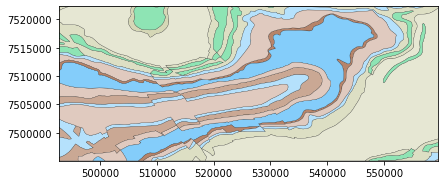

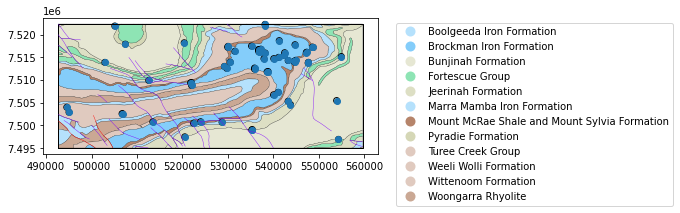

In [8]:
import os
import hjson
from map2loop.project import Project
%matplotlib inline
proj = Project( 
                 loopdata_state = "WA",)

proj.update_config(
                    out_dir='./test',
                    bbox_3d=bbox_3d,
                    proj_crs={'init': 'EPSG:28350'},
                    overwrite='true',
                  )

  0%|          | 0/100 [00:00<?, ?it/s]

Generating topology analyser input...
52  polygons
Successful parameter load
Output directory created at: ./test/graph
Topology analysis complete.

Resolving ambiguities using ASUD...	output_dir:Done.
Generating topology graph display and unit groups...
0    'Fortescue Group', 'anchor': 'n', 'fontStyle': 'bold'
1    'Hamersley Group', 'anchor': 'n', 'fontStyle': 'bold'
2    'Turee Creek Group', 'anchor': 'n', 'fontStyle': 'bold'
3    'Boolgeeda Iron Formation'
4    'Brockman Iron Formation'
5    'Bunjinah Formation'
6    'Fortescue Group'
7    'Jeerinah Formation'
8    'Marra Mamba Iron Formation'
9    'Mount McRae Shale and Mount Sylvia Formation'
10    'Pyradie Formation'
11    'Turee Creek Group'
12    'Weeli Wolli Formation'
13    'Wittenoom Formation'
14    'Woongarra Rhyolite'
Topology figure saved to ./test/tmp/topology-fig.png


 10%|█         | 10/100 [00:01<00:12,  7.05it/s]

Done
Fetching DTM...  bbox:116.82865964631192 117.68005305502832 -22.751517987300865 -22.30422375060032
Attempt: 0 dtm geotif saved as ./test/dtm/dtm.tif
Done.
reprojected dtm geotif saved as ./test/dtm/dtm_rp.tif


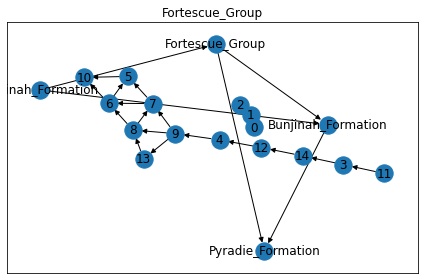

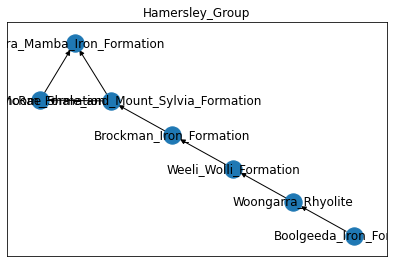

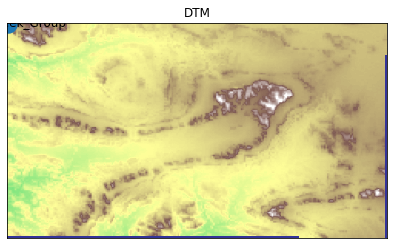

 30%|███       | 30/100 [00:02<00:05, 13.07it/s]

group choices: 1
dtb and dtb_null set to 0
66 orientations saved to ./test/output/orientations.csv


 50%|█████     | 50/100 [00:03<00:02, 23.02it/s]

extra orientations saved as /empty_series_orientations.csv
basal contacts saved allpts =  1664 deci_pts =  459
saved as ./test/tmp/all_contacts.csv and ./test/tmp/contacts.csv
basal contacts without faults saved as ./test/tmp/basal_contacts.shp


 60%|██████    | 60/100 [00:07<00:06,  6.40it/s]

decimated contacts saved as ./test/output/contacts4.csv
All observations n= 66
groups ['Hamersley Group' 'Fortescue Group' 'Turee Creek Group'] 
codes ['Marra Mamba Iron Formation' 'Boolgeeda Iron Formation'
 'Weeli Wolli Formation' 'Mount McRae Shale and Mount Sylvia Formation'
 'Jeerinah Formation' 'Fortescue Group' 'Woongarra Rhyolite'
 'Bunjinah Formation' 'Turee Creek Group' 'Brockman Iron Formation'
 'Wittenoom Formation' 'Pyradie Formation']


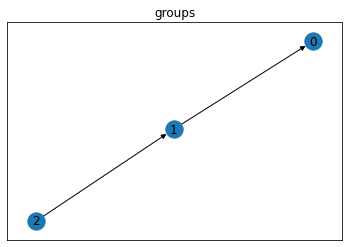

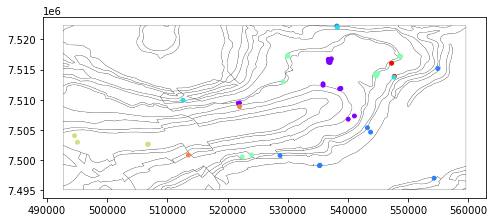

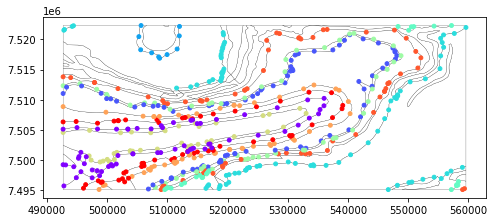

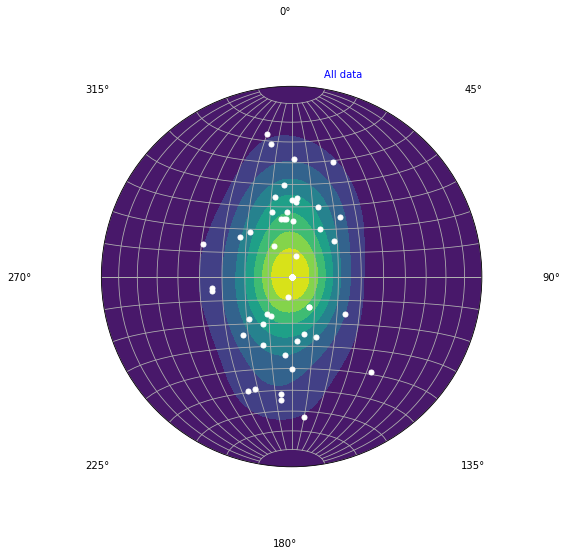

----------------------------------------------------------------------------------------------------------------------
Hamersley Group observations n= 48
strike/dip of girdle 186.03135495845387 / 87.52602496467192


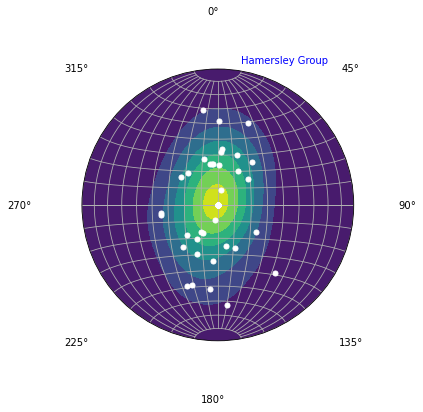

----------------------------------------------------------------------------------------------------------------------
Fortescue Group observations n= 14
strike/dip of girdle 166.46541349679694 / 88.68898043764841


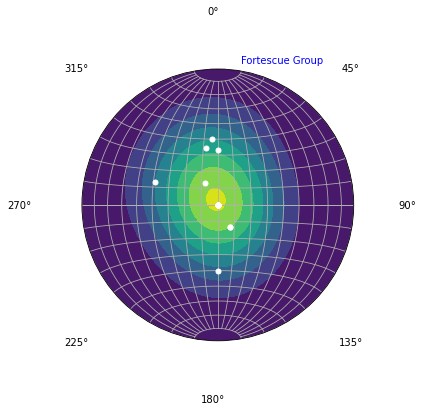

----------------------------------------------------------------------------------------------------------------------
Turee Creek Group observations n= 4
strike/dip of girdle 176.3079195577193 / 87.03961320029661


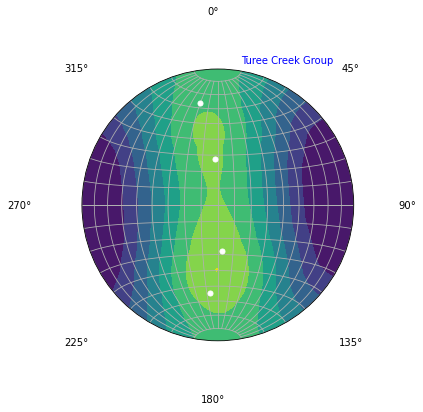

rbf_split 0 7371
['Hamersley Group', 'Fortescue Group', 'Turee Creek Group']
134 55
interpolated dips


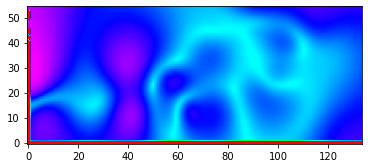

interpolated dip directions


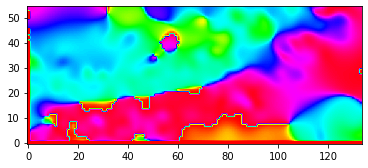

interpolated contacts


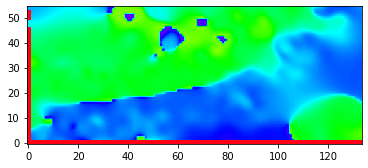

 70%|███████   | 70/100 [00:14<00:09,  3.26it/s]

fault orientations saved as ./test/output/fault_orientations.csv
fault positions saved as ./test/output/faults.csv
fault dimensions saved as ./test/output/fault_dimensions.csv


 90%|█████████ | 90/100 [00:50<00:09,  1.01it/s]

Fault Fault_7344 with displacement of 535 capped to 523.7732100081987
Fault Fault_962 with displacement of 834 capped to 175.35348393442075
Fault Fault_965 with displacement of 827 capped to 574.3070170229846
Fault Fault_2235 with displacement of 569 capped to 400.8802066537339
Fault Fault_2843 with displacement of 1337 capped to 1189.4294950768087
Fault Fault_5298 with displacement of 569 capped to 187.7381175799892
Fault Fault_6000 with displacement of 351 capped to 247.56096017634678
Fault Fault_6205 with displacement of 2097 capped to 632.5229705904732
Fault Fault_12645 with displacement of 1355 capped to 435.28923322513344
Fault Fault_16769 with displacement of 535 capped to 394.20913263247763
fault displacement estimates saved as ./test/output/fault_displacements3.csv
near-fault orientations saved as ./test/tmp/ex_f_combo_full.csv
near-fault orientations saved as ./test/tmp/ex_f_combo_full.csv
0 Turee_Creek_Group
1 Hamersley_Group
2 Fortescue_Group
pluton contacts and orientation

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]

cycles []


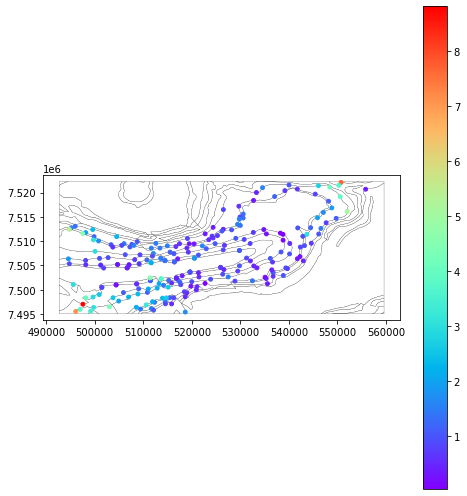

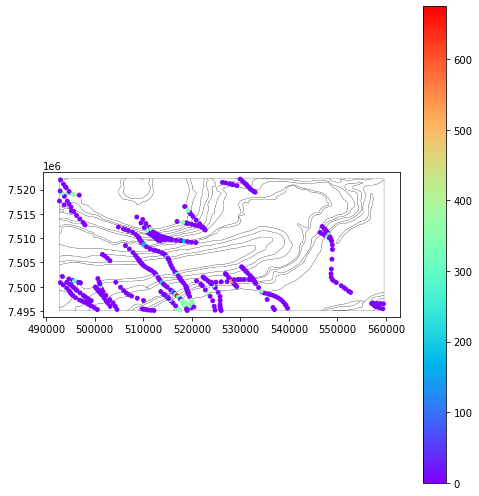

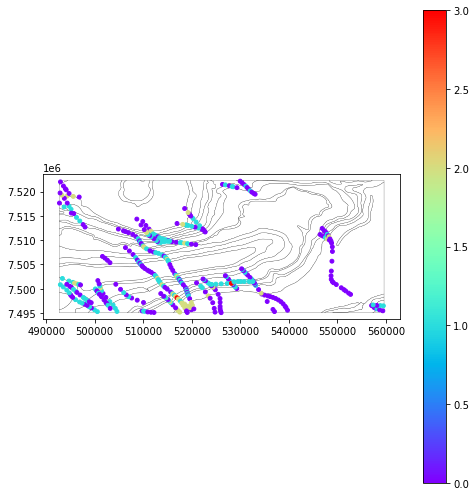

In [9]:
proj.run()

# Converting map2loop output to LoopStructural input
The map2loop process produces the following outputs that are useful for 3D geological modelling:
* structural data constraining the orientation of stratigraphic units and foliations
* contact location for geological units 
* location of fault traces
* geometry of fault plane
* estimate of fault displacement
* thickness of formations
* stratigraphic offset across faults
* stratigraphic relationships (order of stratigraphic units)
* fault - fault relationships (order of overprinting of faults)

Text(0.5, 1.0, 'Fault network graph')

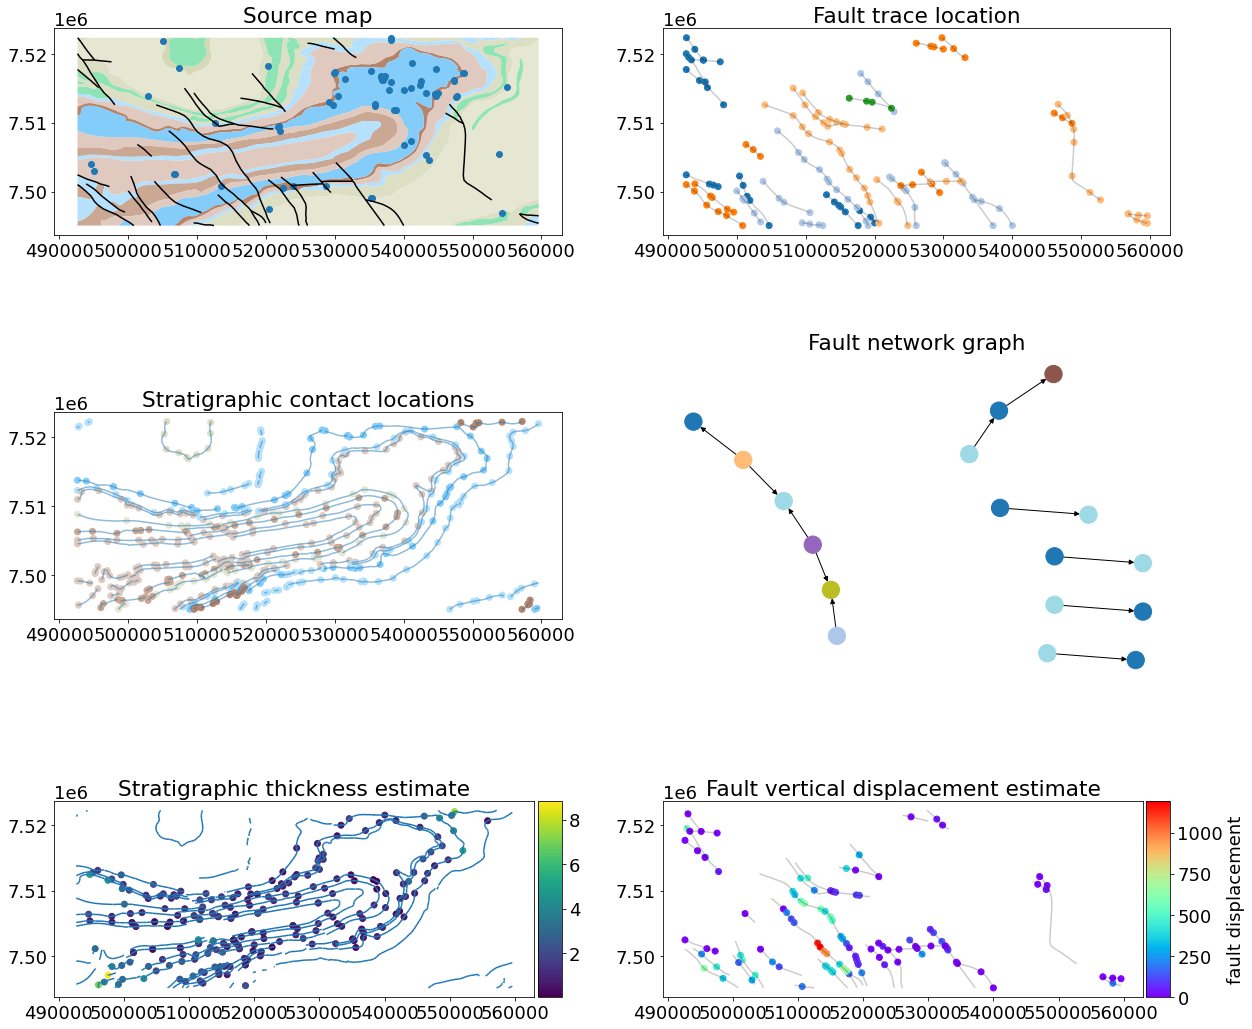

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from networkx.algorithms.components import weakly_connected_components
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
plt.rcParams.update({'font.size': 18})
#  matplotlib import rcParams
# rcParams['fontsize']=22
fig, ax = plt.subplots(3,2,figsize=(20,20))
proj.config.geol_clip.plot(ax=ax[0,0], column=proj.config.c_l['c'],cmap=proj.config.cmap)
proj.config.structure_clip.plot(ax=ax[0,0])
proj.config.faults_clip.plot(ax=ax[0,0],color='black')
proj.config.faults_clip.plot(ax=ax[0,1],color='black',alpha=0.2)
proj.config.faults_clip.plot(ax=ax[2,1],color='black',alpha=0.2)

basal_contacts = geopandas.read_file(proj.config.tmp_path+'/basal_contacts.shp')

ax[0,0].set_title('Source map')
basal_contacts.plot(ax=ax[1,0],alpha=0.5)
basal_contacts.plot(ax=ax[2,0])

contacts = pd.read_csv(proj.config.output_path+'/contacts_clean.csv')
strat_id, code = pd.factorize(contacts['formation'])

faults = pd.read_csv(proj.config.output_path+'/faults.csv')
fault_id, fault_code = pd.factorize(faults['formation'])
thickness = pd.read_csv(proj.config.output_path+'/formation_thicknesses_norm.csv')
fault_displacements = pd.read_csv(proj.config.output_path+'/fault_displacements3.csv')
ax[1,0].scatter(contacts['X'],contacts['Y'],c=strat_id,cmap=proj.config.cmap)
ax[0,1].scatter(faults['X'],faults['Y'],c=fault_id,cmap='tab20',vmin=0,vmax=len(fault_id)-1)
thick_colormap = ax[2,0].scatter(thickness['x'],thickness['y'],c=thickness['norm_th'])
divider=make_axes_locatable(ax[2,0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(thick_colormap, cax=cax1)
# fig.colorbar(,ax=ax[2,0])
displacement_colormap = ax[2,1].scatter(fault_displacements['X'],fault_displacements['Y'],c=fault_displacements['vertical_displacement'],cmap='rainbow')
divider = make_axes_locatable(ax[2,1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(displacement_colormap,cax=cax2,label='fault displacement')
fault_displacements['vx'] = np.sin(np.deg2rad(fault_displacements['downthrow_dir']))
fault_displacements['vy'] = np.cos(np.deg2rad(fault_displacements['downthrow_dir']))

# ax[0,2].quiver(fault_displacements['X'],fault_displacements['Y'],fault_displacements['vx'],fault_displacements['vy'])
# proj.config.faults_clip.
# ax[0,2].plot()

ax[0,1].set_title('Fault trace location')
ax[2,1].set_title('Fault vertical displacement estimate')
ax[1,0].set_title('Stratigraphic contact locations')
ax[2,0].set_title('Stratigraphic thickness estimate')


G = nx.read_gml(proj.config.tmp_path+'/fault_network.gml')
colours = np.arange(len(fault_code))
nodes = [n for n in fault_code]
node_colours = {nodes[i]: colours[i] for i in range(len(colours))}
pos=nx.nx_agraph.graphviz_layout(G,prog="neato")
colours = np.arange(len(G.nodes))
for h in weakly_connected_components(G):
    sub = G.subgraph(h)
    colours = [node_colours[n] for n in sub.nodes]
    nx.draw(sub,pos,node_color=colours,cmap='tab20',ax=ax[1,1])
ax[1,1].set_title('Fault network graph')

## Processing faults
LoopStructural represents faults using a fault frame where three scalar fields are modelled:
1. Fault surface - `coord=0`
2. Fault slip direction - `coord=1`
3. Fault extent - `coord=2`

The fault surface is interpolated using the fault location points and the orientation of the fault surface. The fault frame is build by using the ellipsoid dimensions (fault extent, fault influence distance and fault depth) combined with the fault slip and fault center. Constraints are added to build the scalar fields for the fault frame. 


**Where there are observations of the fault slip direction (e.g. fault kinematic observations) these can be used as observations in the dataframe by specifying the coordinate = 1.**


## Building the stratigraphic dataset

* `contacts_clean` is a table that contains the location and name of the basal contact for a stratigraphic horizon. 
* `stratigraphic_order` is a table that contains the relative stratigraphic column for the map
* `thicknesses` is a table containing the summary of the thicknesses of each stratigraphic unit.
* `orientations` is a table containing the location and strike/dip of a structural observation.

To build an implicit model this dataset needs to be converted into input for LoopStructural. We need to define which geological units are conformable, which will define which units can be represented using different isosurfaces of the same scalar field. To do this we identify a reference horizon and define the relative distance from this reference horizon to every contact by accumulating the thickness of the units. This will define the value of the implicit function that is being interpolated. 

To build this dataset we use the `stratigraphic_order` table which characterises the local stratigraphy for the map by identifying which groups the stratigraphic units are in and the relative location of each stratigraphic unit in the group.  
Where there are multiple groups on the map it is possible to determine whether different groups are conformable. Another file `supergroups.csv` provides this information, each line in this file defines the members of a supergroups. 

When modelling areas with sparse datasets (e.g. primarily from mapsheets) it is often preferable to as many geological interfaces into the same implicit function. This is because the orientation observations, and the geometry of different horizons will help to constrain the other units that may not be as well constrained in the outcrop. 

LoopStructural automatically calculates the value of the implicit function for each stratigraphic unit using the stratigraphic order and the estimated unit thickness from map2loop. The orientation observations constrain the geometry of the geological surface at a particular location. LoopStructural converts the dip and dip direction into a normal vector observation. 

In [15]:
import pandas as pd
contacts_clean = pd.read_csv(proj.config.output_path+'/contacts_clean.csv',index_col='index')
orientations = pd.read_csv(proj.config.output_path+'/contact_orientations.csv')
thicknesses = pd.read_csv(proj.config.output_path+'/formation_summary_thicknesses.csv')
stratigraphic_order = pd.read_csv(proj.config.tmp_path+'/all_sorts.csv',index_col='index')

In [16]:
orientations

,X,Y,Z,azimuth,dip,polarity,formation
0,518417.475403,7.494639e+06,522.242291,305.605254,24.942743,1,Jeerinah_Formation
1,516011.179835,7.494796e+06,562.753454,312.332717,24.941626,1,Jeerinah_Formation
2,514659.774908,7.494188e+06,572.592975,308.596969,24.941745,1,Jeerinah_Formation
3,512321.495607,7.492540e+06,615.991638,334.993760,24.941619,1,Jeerinah_Formation
4,510577.065983,7.491477e+06,549.233990,320.154320,24.941475,1,Jeerinah_Formation
...,...,...,...,...,...,...,...
1019,509948.098494,7.496202e+06,617.487966,337.401645,24.938291,1,Mount_McRae_Shale_and_Mount_Sylvia_Formation
1020,507733.128423,7.495210e+06,600.402343,324.469961,24.937574,1,Mount_McRae_Shale_and_Mount_Sylvia_Formation
1021,507537.309287,7.494231e+06,596.318894,328.255242,24.938242,1,Wittenoom_Formation
1022,510642.019241,7.495251e+06,574.432935,150.603764,24.938906,1,Wittenoom_Formation


## Loop Structural

In [20]:
# Define project bounds
minx,miny,maxx,maxy = proj.config.bbox
model_base = proj.config.bbox_3d['base']
model_top = proj.config.bbox_3d['top']


In [21]:
# checking files are consistent for loopstructural
if(not os.path.exists(proj.config.fault_file_csv)):
    f=open(output_path + '/fault_displacements3.csv','w')
    f.write('X,Y,fname,apparent_displacement,vertical_displacement,downthrow_dir\n')
    f.close()
    f=open(proj.config.output_path + '/fault_orientations.csv','w')
    f.write('X,Y,Z,DipDirection,dip,DipPolarity,formation\n')
    f.close()
    f=open(proj.config.output_path + '/faults.csv','w')
    f.write('X,Y,Z,formation\n')
    f.close()
    f=open(proj.config.output_path + '/fault-fault-relationships.csv','w')
    f.write('fault_id\n')
    f.close()
    f=open(proj.config.output_path + '/group-fault-relationships.csv','w')
    f.write('group\n')
    f.close()
#defining a bounding box
f=open(proj.config.tmp_path+'/bbox.csv','w')
f.write('minx,miny,maxx,maxy,lower,upper\n')
ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
f.write(ostr)
f.close()

In [22]:

fault_params = {'interpolatortype':'FDI',
                'nelements':5e4,
                'step':10,
                'fault_buffer':0.1,
                'solver':'pyamg',
#                 overprints:overprints,
                'cpw':10,
                'npw':10}
foliation_params = {'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
                    'nelements':1e5,  # how many tetras/voxels
                    'buffer':0.8,  # how much to extend nterpolation around box
                    'solver':'pyamg',
                    'damp':True}


model, m2l_data = GeologicalModel.from_map2loop_directory(proj.config.project_path,
                                                              evaluate=False,
                                                          fault_params=fault_params,
                                                          rescale=False,
                                                          foliation_params=foliation_params)


In [23]:
model.update()

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
view = LavaVuModelViewer(model)
view.add_model_surfaces()
# view.add_data(model['supergroup_0'])
view.interactive()

  0%|          | 0/45 [00:00<?, ?it/s]

2021-04-20 02:24:00,469 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-20 02:24:00,469 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-20 02:24:00,469 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box


Adding surfaces took 6.52834415435791 seconds
